In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.signal import resample
import gc
import glob
import matplotlib.pyplot as plt
import keras_tuner as kt
import os
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from scipy import signal
from keras.layers import BatchNormalization, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, ReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
import keras_tuner as kt
import time
from keras import layers
import keras_tuner as kt
import keras
import shutil
from tensorflow.keras.callbacks import ModelCheckpoint
from quantizeml.models import quantize, QuantizationParams
from cnn2snn import convert, check_model_compatibility, quantize_layer
from keras.optimizers import Adam
import matplotlib.cm as cm

In [2]:

def evaluate_model(model, x_test, y_test):
    print("Evaluating model...")

    start_time = time.time()
    y_pred = model.predict(x_test)
    end_time = time.time()
    prediction_time = end_time - start_time

    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    labels_cm = ["N", "SVEB", "VEB", "F", "Q"]

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred_classes)
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_true, y_pred_classes)
    auc_roc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted')

    # Calculate specificity for each class
    specificities = []
    for i in range(len(labels_cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity = tn / (tn + fp)
        specificities.append(specificity)

    # Print results
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"AUC-ROC (Weighted): {auc_roc:.4f}")
    print(f"Average Prediction Time per Sample: {prediction_time / len(x_test):.6f} seconds")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=labels_cm))
    print("\nClass-wise Specificity:")
    for label, spec in zip(labels_cm, specificities):
        print(f"{label}: {spec:.4f}")

    # Visualizations
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_cm, yticklabels=labels_cm)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    plt.figure(figsize=(10, 8))
    for i, label in enumerate(labels_cm):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
        auc = roc_auc_score(y_test[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f'{label}(AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return {
        'accuracy': acc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'auc_roc': auc_roc,
        'specificities': specificities,
        'avg_prediction_time': prediction_time / len(x_test)
    }


In [3]:
def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()


In [4]:


def analyze_weight_distribution(original_model, quantized_model, layer_idx):
    """Analyze weight value distributions between original and quantized models for a given layer."""
    orig_layer = original_model.layers[layer_idx]
    quant_layer = quantized_model.layers[layer_idx]

    # Check if the layer has weights
    if not orig_layer.get_weights():
        print(f"Skipping Layer {layer_idx} ({orig_layer.name}): No weights found.")
        return

    # Extract weight values
    original_weights = orig_layer.get_weights()[0].flatten() if len(orig_layer.get_weights()) > 0 else None
    quantized_weights = quant_layer.get_weights()[0].flatten() if len(quant_layer.get_weights()) > 0 else None

    if original_weights is not None and quantized_weights is not None:
        plt.figure(figsize=(12, 6))
        plt.hist(original_weights, bins=100, alpha=0.5, label="Original Weights", color="blue")
        plt.hist(quantized_weights, bins=100, alpha=0.5, label="Quantized Weights", color="orange")
        plt.title(f"Weight Distribution: Layer {layer_idx} ({orig_layer.name})")
        plt.xlabel("Weight Values")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()
    else:
        print(f"Skipping Layer {layer_idx} ({orig_layer.name}): No valid weight data.")

def analyze_bias_distribution(original_model, quantized_model, layer_idx):
    """Analyze bias value distributions between original and quantized models for a given layer."""
    orig_layer = original_model.layers[layer_idx]
    quant_layer = quantized_model.layers[layer_idx]

    # Check if the layer has biases
    if not orig_layer.get_weights() or len(orig_layer.get_weights()) < 2:
        print(f"Skipping Layer {layer_idx} ({orig_layer.name}): No biases found.")
        return

    # Extract bias values
    original_biases = orig_layer.get_weights()[1].flatten()
    quantized_biases = quant_layer.get_weights()[1].flatten()

    plt.figure(figsize=(12, 6))
    plt.hist(original_biases, bins=100, alpha=0.5, label="Original Biases", color="green")
    plt.hist(quantized_biases, bins=100, alpha=0.5, label="Quantized Biases", color="red")
    plt.title(f"Bias Distribution: Layer {layer_idx} ({orig_layer.name})")
    plt.xlabel("Bias Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

def analyze_all_layers(original_model, quantized_model):
    """Loops through all layers and analyzes weights and biases where applicable."""
    for layer_idx, layer in enumerate(quantized_model.layers):
        print(f"\nAnalyzing Layer {layer_idx}: {layer.name}")

        # Check if layer has weights
        if layer.get_weights():
            analyze_weight_distribution(original_model, quantized_model, layer_idx)
            analyze_bias_distribution(original_model, quantized_model, layer_idx)
        else:
            print(f"Skipping {layer.name}: No trainable weights or biases.")

# **Usage**
# analyze_all_layers(original_model, quantized_model)


# **Usage Example**
# analyze_all_layers(original_model, quantized_model)


In [5]:

def preprocess_for_quantization(data):
    # Scale data to [0, 255] range for 8-bit quantization
    data_scaled = ((data - data.min()) / (data.max() - data.min()) * 255).astype('uint8') 
    return data_scaled


In [6]:
def improved_model_builder(hp):
    inputs = keras.Input(shape=(128, 128, 1))

    # First Convolutional Block - reduced filters
    x = layers.Conv2D(16, (3, 3), padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_1', 1e-4, 1e-2, sampling='LOG')))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Dropout(hp.Float('dropout_1', 0.3, 0.5, step=0.05))(x)

    # Second Convolutional Block - moderate filters
    x = layers.Conv2D(32, (3, 3), padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_2', 1e-4, 1e-2, sampling='LOG')))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Dropout(hp.Float('dropout_2', 0.3, 0.5, step=0.05))(x)

    # Third Convolutional Block - moderate filters
    x = layers.Conv2D(64, (3, 3), padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_3', 1e-4, 1e-2, sampling='LOG')))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Dropout(hp.Float('dropout_3', 0.3, 0.5, step=0.05))(x)

    # Global Average Pooling instead of Flatten
    x = layers.Flatten()(x)

    # Single Dense Layer with reduced units
    x = layers.Dense(hp.Int('dense_units', 64, 128, step=32),
                     kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_dense', 1e-4, 1e-2, sampling='LOG')))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(hp.Float('dropout_dense', 0.3, 0.5, step=0.05))(x)

    # Output Layer
    outputs = layers.Dense(5)(x)
    model = keras.Model(inputs, outputs)

    # Conservative learning rate
    lr = hp.Float('learning_rate', 1e-5, 1e-3, sampling='LOG')
    optimizer = keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model


In [7]:
def create_cnn_model():
    model = keras.Sequential([
        # Input layer
        keras.layers.Rescaling(1. / 255, input_shape=(128, 128, 1)),

        # First Convolutional Block
        layers.BatchNormalization(),
        layers.Conv2D(16, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((3, 3), padding='same'),
        layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((3, 3), padding='same'),
        layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((3, 3), padding='same'),
        layers.Dropout(0.2),

        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(96),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dropout(0.2),

        # Output Layer
        layers.Dense(5)
    ], name='cnn_model')

    return model


In [8]:

clear_memory()
model = create_cnn_model()

# Optional: Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Change to sparse_categorical_crossentropy
    metrics=['accuracy']
)

# Print model summary for verification
model.summary()

# Set GPU as the visible device for TensorFlow
os.environ["CUDA_VISIBLE_DEVICES"] = "0"




Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 batch_normalization (Batch  (None, 128, 128, 1)       4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu (ReLU)                (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 43, 43, 16)        

In [9]:
save_dir = r'D:\ECG project\Save'
X_train = np.load(os.path.join(save_dir, 'X_train2.npy'))
y_train = np.load(os.path.join(save_dir, 'y_train2.npy'))
X_val = np.load(os.path.join(save_dir, 'X_val2.npy'))
y_val = np.load(os.path.join(save_dir, 'y_val2.npy'))
X_test = np.load(os.path.join(save_dir, 'X_test2.npy'))
y_test = np.load(os.path.join(save_dir, 'y_test2.npy'))


#preserving the y values one-hot encoded as to use it in tuner
y_train_tuner = y_train
y_val_tuner = y_val
y_test_tuner = y_test


# Convert one-hot encoded labels to integer labels
y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)
y_test = np.argmax(y_test, axis=1)


In [10]:

# Normalize the dataset
X_train_q = preprocess_for_quantization(X_train.astype('uint8'))
X_val_q = preprocess_for_quantization(X_val.astype('uint8'))
X_test_q =preprocess_for_quantization(X_test.astype('uint8'))


Trial 5 Complete [01h 16m 45s]
val_accuracy: 0.9820126295089722

Best val_accuracy So Far: 0.9895964860916138
Total elapsed time: 07h 52m 21s
Best hyperparameters: {'l2_1': 0.00666426849632118, 'dropout_1': 0.5, 'l2_2': 0.008651318675709212, 'dropout_2': 0.3, 'l2_3': 0.0003173709295050098, 'dropout_3': 0.35, 'dense_units': 128, 'l2_dense': 0.0014173916216214898, 'dropout_dense': 0.45, 'learning_rate': 0.0005734429228475826}
Epoch 1/20
965/965 [==============================] - ETA: 0s - loss: 0.5700 - accuracy: 0.9405

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 250s 256ms/step - loss: 0.5700 - accuracy: 0.9405 - val_loss: 0.3662 - val_accuracy: 0.9725 - lr: 5.7344e-04
Epoch 2/20
965/965 [==============================] - ETA: 0s - loss: 0.3588 - accuracy: 0.9669

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 243s 252ms/step - loss: 0.3588 - accuracy: 0.9669 - val_loss: 0.3436 - val_accuracy: 0.9714 - lr: 5.7344e-04
Epoch 3/20
965/965 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.9712

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 242s 250ms/step - loss: 0.3396 - accuracy: 0.9712 - val_loss: 0.3240 - val_accuracy: 0.9787 - lr: 5.7344e-04
Epoch 4/20
965/965 [==============================] - ETA: 0s - loss: 0.3608 - accuracy: 0.9709

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 247s 255ms/step - loss: 0.3608 - accuracy: 0.9709 - val_loss: 0.3160 - val_accuracy: 0.9791 - lr: 5.7344e-04
Epoch 5/20
965/965 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.9730

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 266s 275ms/step - loss: 0.3490 - accuracy: 0.9730 - val_loss: 0.3128 - val_accuracy: 0.9806 - lr: 5.7344e-04
Epoch 6/20
965/965 [==============================] - ETA: 0s - loss: 0.3443 - accuracy: 0.9737

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 251s 260ms/step - loss: 0.3443 - accuracy: 0.9737 - val_loss: 0.3033 - val_accuracy: 0.9844 - lr: 5.7344e-04
Epoch 7/20
965/965 [==============================] - 233s 242ms/step - loss: 0.3446 - accuracy: 0.9726 - val_loss: 0.3132 - val_accuracy: 0.9824 - lr: 5.7344e-04
Epoch 8/20
965/965 [==============================] - 234s 243ms/step - loss: 0.3471 - accuracy: 0.9733 - val_loss: 0.3074 - val_accuracy: 0.9832 - lr: 5.7344e-04
Epoch 9/20
965/965 [==============================] - 238s 246ms/step - loss: 0.3286 - accuracy: 0.9756 - val_loss: 0.3166 - val_accuracy: 0.9826 - lr: 5.7344e-04
Epoch 10/20
965/965 [==============================] - ETA: 0s - loss: 0.3269 - accuracy: 0.9749

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 242s 251ms/step - loss: 0.3269 - accuracy: 0.9749 - val_loss: 0.2989 - val_accuracy: 0.9824 - lr: 5.7344e-04
Epoch 11/20
965/965 [==============================] - ETA: 0s - loss: 0.3267 - accuracy: 0.9748

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 243s 252ms/step - loss: 0.3267 - accuracy: 0.9748 - val_loss: 0.2955 - val_accuracy: 0.9837 - lr: 5.7344e-04
Epoch 12/20
965/965 [==============================] - ETA: 0s - loss: 0.2507 - accuracy: 0.9834

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 250s 259ms/step - loss: 0.2507 - accuracy: 0.9834 - val_loss: 0.1925 - val_accuracy: 0.9868 - lr: 1.1469e-04
Epoch 13/20
965/965 [==============================] - ETA: 0s - loss: 0.1763 - accuracy: 0.9862

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 250s 259ms/step - loss: 0.1763 - accuracy: 0.9862 - val_loss: 0.1485 - val_accuracy: 0.9873 - lr: 1.1469e-04
Epoch 14/20
965/965 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9872

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 249s 258ms/step - loss: 0.1457 - accuracy: 0.9872 - val_loss: 0.1308 - val_accuracy: 0.9878 - lr: 1.1469e-04
Epoch 15/20
965/965 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.9874

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 243s 252ms/step - loss: 0.1328 - accuracy: 0.9874 - val_loss: 0.1173 - val_accuracy: 0.9894 - lr: 1.1469e-04
Epoch 16/20
965/965 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.9874

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 249s 258ms/step - loss: 0.1274 - accuracy: 0.9874 - val_loss: 0.1151 - val_accuracy: 0.9889 - lr: 1.1469e-04
Epoch 17/20
965/965 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9882

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 250s 259ms/step - loss: 0.1192 - accuracy: 0.9882 - val_loss: 0.1116 - val_accuracy: 0.9886 - lr: 1.1469e-04
Epoch 18/20
965/965 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.9880

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 243s 251ms/step - loss: 0.1165 - accuracy: 0.9880 - val_loss: 0.1062 - val_accuracy: 0.9895 - lr: 1.1469e-04
Epoch 19/20
965/965 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9883

C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Youssef Amr\PycharmProjects\scientificProject\wandb\run-20250223_203604-7cyy9ybe\files\model-best)... Done. 0.1s


965/965 [==============================] - 249s 258ms/step - loss: 0.1111 - accuracy: 0.9883 - val_loss: 0.1046 - val_accuracy: 0.9891 - lr: 1.1469e-04
Epoch 20/20
965/965 [==============================] - 244s 253ms/step - loss: 0.1179 - accuracy: 0.9872 - val_loss: 0.1122 - val_accuracy: 0.9866 - lr: 1.1469e-04


C:\Users\Youssef Amr\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluating model...
322/322 [==============================] - 17s 49ms/step
Accuracy: 0.9906
F1 Score (Weighted): 0.9906
Precision (Weighted): 0.9906
Recall (Weighted): 0.9906
AUC-ROC (Weighted): 0.9993
Average Prediction Time per Sample: 0.003260 seconds

Confusion Matrix:
[[1994   22    3   11    9]
 [  26 2022    0    0    1]
 [   6    0 2023   12    4]
 [   2    0    0 2051    1]
 [   0    0    0    0 2098]]

Classification Report:
              precision    recall  f1-score   support

           N       0.98      0.98      0.98      2039
        SVEB       0.99      0.99      0.99      2049
         VEB       1.00      0.99      0.99      2045
           F       0.99      1.00      0.99      2054
           Q       0.99      1.00      1.00      2098

    accuracy                           0.99     10285
   macro avg       0.99      0.99      0.99     10285
weighted avg       0.99      0.99      0.99     10285


Class-wise Specificity:
N: 0.9959
SVEB: 0.9973
VEB: 0.9996
F: 0.9972


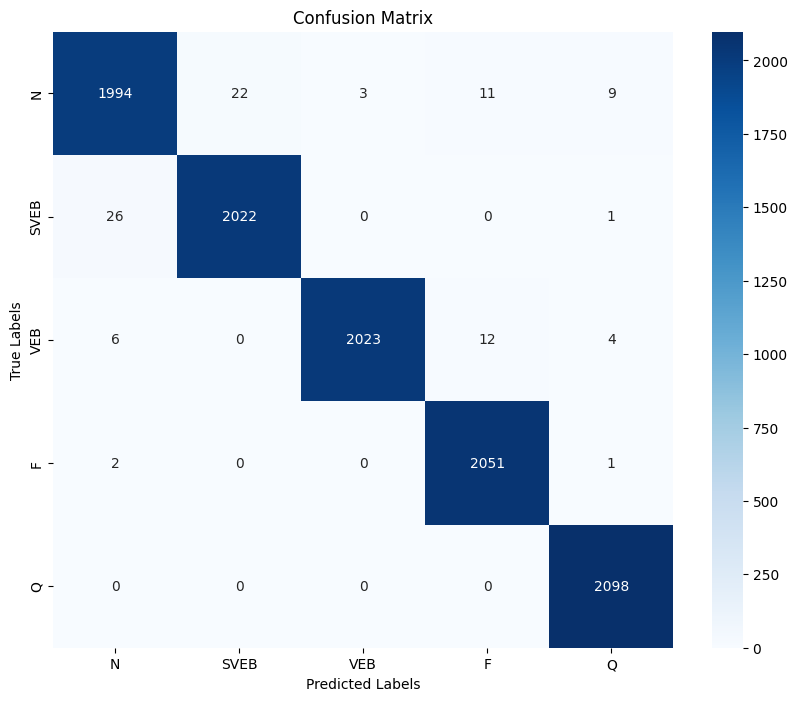

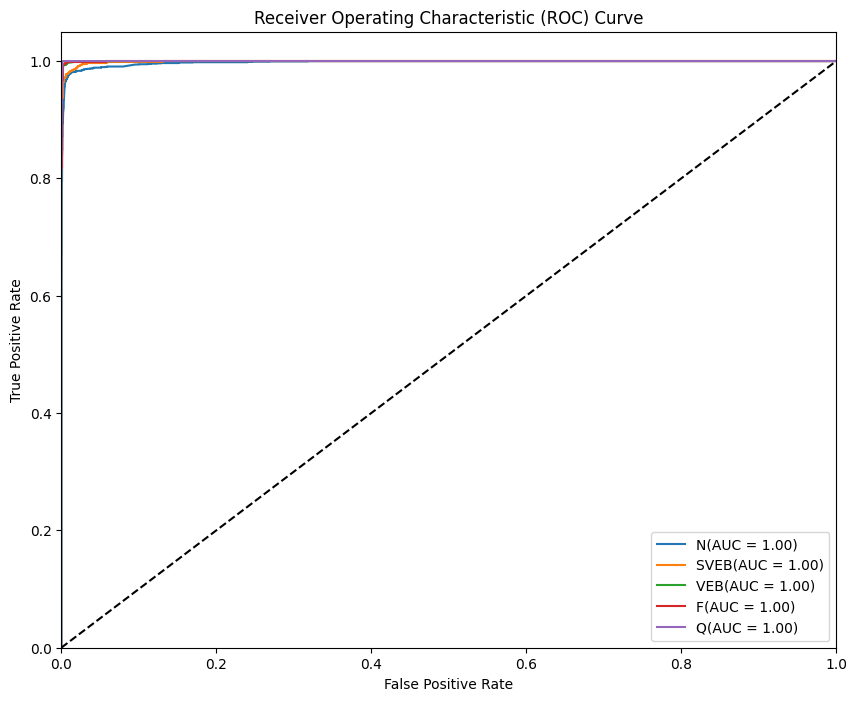

In [12]:
"""#Model is now trained it will just be loaded
best_model_path = r'D:\ECG project\Results\Correct Model (latest)\Model after inserting tuner evaluating the model gave error\model_with_tuner_functions_on_correct_model.h5'
model = keras.models.load_model(best_model_path)
evaluate_model(model, X_test_q, y_test_tuner) # this gave an error with y_test it will now be tested with y_test_tuner
"""
import wandb
from wandb.integration.keras import WandbCallback

os.environ['WANDB_API_KEY'] = '23961d3c5d1196fa16f411ec01b3a6c88223c6d2'
wandb.init(project="ecg_classification_2", name="hyperparameter_tuning_2")
#############################################################################
tuner_dir = 'ecg_tuner_improved'
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

# Define callbacks with increased patience
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,  # Increased patience
        restore_best_weights=True,
        min_delta=1e-4  # Minimum improvement required
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.2,  # More aggressive LR reduction
        patience=5,
        min_lr=1e-7,
        min_delta=1e-4
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(tuner_dir, 'checkpoint_{epoch:02d}_{val_accuracy:.2f}.h5'),
        save_best_only=True,
        monitor='val_accuracy'
    ),
    WandbCallback()
]

# Configure tuner with more trials
tuner = kt.RandomSearch(
    improved_model_builder,
    objective='val_accuracy',
    max_trials=5,  # Increased number of trials
    executions_per_trial=1,
    directory=tuner_dir,
    project_name='ecg_classification_improved',
    overwrite=True
)

# Main training loop with error handling
try:
    tuner.search(
        X_train_q, y_train_tuner,
        epochs=20,  # Increased epochs
        batch_size=32,
        validation_data=(X_val_q, y_val_tuner),
        callbacks=callbacks,
        verbose=1
    )

    if len(tuner.oracle.trials) == 0:
        print("No trials completed successfully. Using default hyperparameters.")
        model = improved_model_builder(kt.HyperParameters())
    else:
        best_hp = tuner.get_best_hyperparameters()[0]
        print("Best hyperparameters:", best_hp.values)
        #
        wandb.config.update(best_hp.values)  # 🟢 New line added to log best hyperparameters in WandB
        model = improved_model_builder(best_hp)

    # Final training with best model
    history = model.fit(
        X_train_q, y_train_tuner,
        epochs=20,
        batch_size=32,
        validation_data=(X_val_q, y_val_tuner),
        callbacks=callbacks,
        verbose=1
    )
    model.save(os.path.join(save_dir, 'model_with_tuner_functions_on_correct_model_wandb.h5'))
    evaluate_model(model, X_test_q, y_test_tuner)

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Using default model configuration...")
    model = improved_model_builder(kt.HyperParameters())

    history = model.fit(
        X_train_q, y_train_tuner,
        epochs=20,
        batch_size=32,
        validation_data=(X_val_q, y_val_tuner),
        callbacks=callbacks,
        verbose=1
    )

    model.save(os.path.join(save_dir, 'default_model_improved.h5'))
    evaluate_model(model, X_test_q, y_test_tuner)

#############################################################################################
# Train the model



322/322 [==============================] - 15s 47ms/step
1
Original Model F1 Score: 0.9906


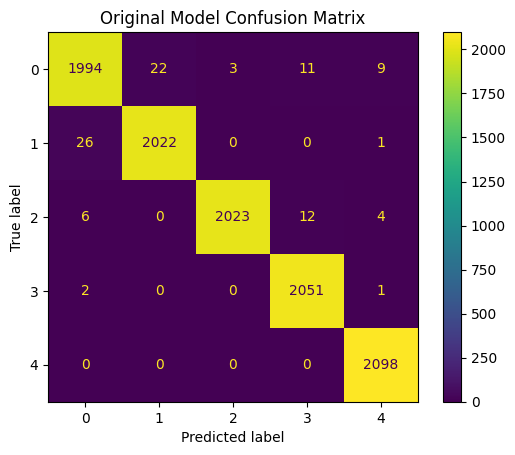

In [13]:
# Original Model Evaluation
original_preds = model.predict(X_test_q)
original_preds = np.argmax(original_preds, axis=1)
print(original_preds[0])
# y_true = np.argmax(y_test, axis=1)
y_true = y_test
print(
    f"Original Model F1 Score: {classification_report(y_true, original_preds, output_dict=True)['weighted avg']['f1-score']:.4f}")
ConfusionMatrixDisplay(confusion_matrix(y_true, original_preds)).plot()
plt.title("Original Model Confusion Matrix")
plt.show()


1024/1024 [==============================] - 5s 4ms/step
Model input shape: (None, 128, 128, 1)
Model output shape: (None, 5)
X_test shape (10285, 128, 128)



Test accuracy after quantization and compiling: 0.9903743267059326
322/322 [==============================] - 33s 94ms/step
Quantized Model F1 Score: 0.9904


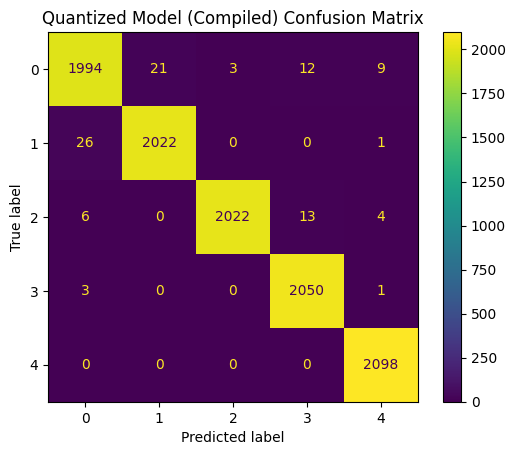

Epoch 1/5
965/965 [==============================] - 232s 240ms/step - loss: 0.1065 - accuracy: 0.9901 - val_loss: 0.1010 - val_accuracy: 0.9898
Epoch 2/5
965/965 [==============================] - 225s 233ms/step - loss: 0.0980 - accuracy: 0.9913 - val_loss: 0.0949 - val_accuracy: 0.9901
Epoch 3/5
965/965 [==============================] - 224s 232ms/step - loss: 0.0909 - accuracy: 0.9917 - val_loss: 0.0882 - val_accuracy: 0.9907
Epoch 4/5
965/965 [==============================] - 231s 240ms/step - loss: 0.0869 - accuracy: 0.9917 - val_loss: 0.0844 - val_accuracy: 0.9905
Epoch 5/5
965/965 [==============================] - 226s 235ms/step - loss: 0.0810 - accuracy: 0.9921 - val_loss: 0.0815 - val_accuracy: 0.9909
Test accuracy after fine tuning: 0.9903743267059326
322/322 [==============================] - 30s 91ms/step
Quantized Model F1 Score: 0.9904


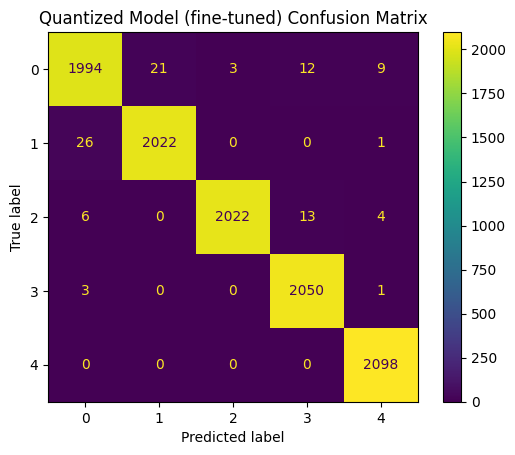

In [14]:
# Convert to MicroPython and Evaluate it
qparams = QuantizationParams(input_weight_bits=8, weight_bits=8, activation_bits=8, per_tensor_activations=True)
quantized_model = quantize(model, qparams=qparams)

print("Model input shape:", quantized_model.input_shape)
print("Model output shape:", quantized_model.output_shape)
print("X_test shape", X_test_q.shape)

quantized_model.compile(  # Use sparse_categorical_crossentropy here too
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
score = quantized_model.evaluate(X_test_q, y_test, verbose=0)

print('Test accuracy after quantization and compiling:', score[1])

quantized_preds = quantized_model.predict(X_test_q)
quantized_preds = np.argmax(quantized_preds, axis=1)
quantized_f1 = classification_report(y_true, quantized_preds, output_dict=True)['weighted avg']['f1-score']
print(f"Quantized Model F1 Score: {quantized_f1:.4f}")
quantized_cm = confusion_matrix(y_true, quantized_preds)
ConfusionMatrixDisplay(quantized_cm, display_labels=range(5)).plot()
plt.title("Quantized Model (Compiled) Confusion Matrix")
plt.show()

model.fit(X_train_q, y_train_tuner, epochs=5, validation_data=(X_val_q, y_val_tuner))

score = quantized_model.evaluate(X_test_q.astype('uint8'), y_test, verbose=0)
print('Test accuracy after fine tuning:', score[1])
quantized_preds = quantized_model.predict(X_test_q)
quantized_preds = np.argmax(quantized_preds, axis=1)
quantized_f1 = classification_report(y_true, quantized_preds, output_dict=True)['weighted avg']['f1-score']
print(f"Quantized Model F1 Score: {quantized_f1:.4f}")
quantized_cm = confusion_matrix(y_true, quantized_preds)
ConfusionMatrixDisplay(quantized_cm, display_labels=range(5)).plot()
plt.title("Quantized Model (fine-tuned) Confusion Matrix")
plt.show()


(10285, 128, 128)
Test accuracy after conversion: 0.9903743267059326
<class 'numpy.ndarray'>
int64
(10285, 1, 5)
[[[0 0 0 0 0]]

 [[0 0 0 0 0]]

 [[0 0 0 0 0]]

 [[0 0 0 0 0]]

 [[0 0 0 0 0]]]
testing ...
Input Label: 1


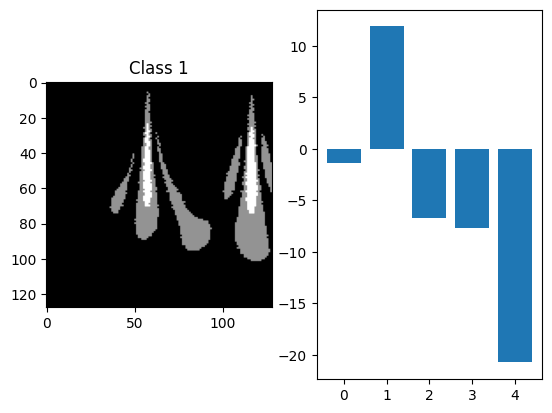

[ -1.3929557  11.893707   -6.6707373  -7.7059083 -20.74132  ]


In [15]:

# Convert to Akida model and Evaluate it
# print("Model compatible for Akida conversion:", check_model_compatibility(model))
model_akida = convert(quantized_model)
print(X_test_q.astype('uint8').shape)

X_test_batched = X_test_q.astype('uint8').reshape(-1, 128, 128, 1)

accuracy = model_akida.evaluate(X_test_batched, y_test)

print('Test accuracy after conversion:', accuracy)

akida_preds = model_akida.predict(X_test_batched)
akida_preds = np.argmax(akida_preds, axis=1)    # Convert predictions to class labels (integers)
print(type(akida_preds))
print(akida_preds.dtype)
print(akida_preds.shape)
print(akida_preds[:5])

# Test a single example
print("testing ...")
sample_image = 0
image = X_test_q[sample_image]  # Use X_test_q (quantized data)

# Reshape the image for the Akida model
outputs = model_akida.predict(image.reshape(1, 128, 128, 1))

print('Input Label: %i' % y_test[sample_image])

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_test_q[sample_image].reshape((128, 128)), cmap=cm.Greys_r)  # Use X_test_q
axarr[0].set_title('Class %d' % y_test[sample_image])
axarr[1].bar(range(5), outputs.squeeze())  # Number of classes is 5
axarr[1].set_xticks(range(5))
plt.show()

print(outputs.squeeze())


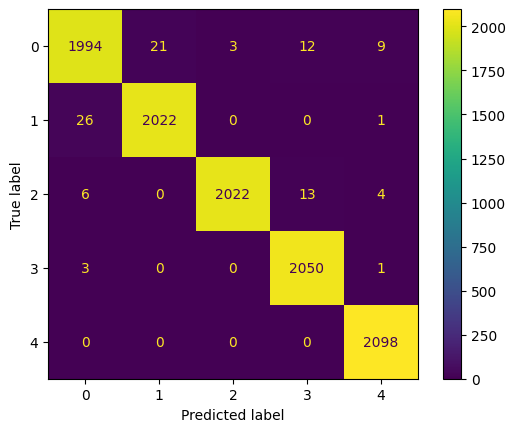

In [16]:

akida_preds_for_confusion = model_akida.predict(X_test_batched.reshape(-1, 128, 128, 1)) #this to make the data shape suitable for confusion matrix
akida_preds_for_confusion  = np.argmax(akida_preds_for_confusion , axis=3)
akida_preds_for_confusion  = akida_preds_for_confusion .reshape(-1)
ConfusionMatrixDisplay(confusion_matrix(y_true, akida_preds_for_confusion )).plot()

In [17]:


def measure_latency(model, X_test, num_runs=10):
    """Measure inference latency of a model."""
    latencies = []
    
    for _ in range(num_runs):
        start_time = time.time()
        _ = model.predict(X_test)
        end_time = time.time()
        
        latencies.append((end_time - start_time) * 1000)  # Convert to milliseconds
    
    avg_latency = np.mean(latencies)
    std_latency = np.std(latencies)
    
    return avg_latency, std_latency

X_test_for_akida = X_test_q.reshape(-1,128,128,1)
# Measure latency for original model
orig_avg, orig_std = measure_latency(model, X_test_q)
print(f"Original Model Latency: {orig_avg:.2f} ms ± {orig_std:.2f} ms")

# Measure latency for quantized model
quant_avg, quant_std = measure_latency(quantized_model, X_test_q)
print(f"Quantized Model Latency: {quant_avg:.2f} ms ± {quant_std:.2f} ms")


# Measure latency for Akida model
akida_avg, akida_std = measure_latency(model_akida,X_test_for_akida )
print(f"Akida Model Latency: {akida_avg:.2f} ms ± {akida_std:.2f} ms")


322/322 [==============================] - 15s 46ms/step
Original Model Latency: 15243.26 ms ± 223.06 ms
322/322 [==============================] - 29s 89ms/step
Quantized Model Latency: 29857.48 ms ± 431.78 ms
Akida Model Latency: 81423.41 ms ± 341.16 ms


In [18]:
"""def plot_scatter(original, compared, title):
    plt.figure(figsize=(6, 6))  # Create a new figure for each plot
    plt.scatter(original, compared, color='red', alpha=0.6, edgecolors='black', label=f"{title}")
    plt.plot([min(original), max(original)], [min(original), max(original)], 
             linestyle='--', color='black', label="Ideal (y=x)")
    plt.xlabel("Original Model Predictions")
    plt.ylabel(f"{title}")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()  # Show each plot separately

# Generate separate scatter plots
plot_scatter(original_preds, quantized_preds, "Quantized Model Predictions")
plot_scatter(original_preds, akida_preds_for_confusion, "Akida Model Predictions")
plot_scatter(original_preds, original_preds, "Ideal (Original vs. Original)")
"""

'def plot_scatter(original, compared, title):\n    plt.figure(figsize=(6, 6))  # Create a new figure for each plot\n    plt.scatter(original, compared, color=\'red\', alpha=0.6, edgecolors=\'black\', label=f"{title}")\n    plt.plot([min(original), max(original)], [min(original), max(original)], \n             linestyle=\'--\', color=\'black\', label="Ideal (y=x)")\n    plt.xlabel("Original Model Predictions")\n    plt.ylabel(f"{title}")\n    plt.title(title)\n    plt.legend()\n    plt.grid(True)\n    plt.show()  # Show each plot separately\n\n# Generate separate scatter plots\nplot_scatter(original_preds, quantized_preds, "Quantized Model Predictions")\nplot_scatter(original_preds, akida_preds_for_confusion, "Akida Model Predictions")\nplot_scatter(original_preds, original_preds, "Ideal (Original vs. Original)")\n'

Epoch 1/5
965/965 [==============================] - 224s 232ms/step - loss: 0.0779 - accuracy: 0.9921 - val_loss: 0.0793 - val_accuracy: 0.9907
Epoch 2/5
965/965 [==============================] - 224s 232ms/step - loss: 0.0767 - accuracy: 0.9916 - val_loss: 0.0744 - val_accuracy: 0.9913
Epoch 3/5
965/965 [==============================] - 224s 232ms/step - loss: 0.0717 - accuracy: 0.9929 - val_loss: 0.0730 - val_accuracy: 0.9912
Epoch 4/5
965/965 [==============================] - 228s 236ms/step - loss: 0.0697 - accuracy: 0.9927 - val_loss: 0.0702 - val_accuracy: 0.9912
Epoch 5/5
965/965 [==============================] - 224s 232ms/step - loss: 0.0674 - accuracy: 0.9931 - val_loss: 0.0699 - val_accuracy: 0.9912


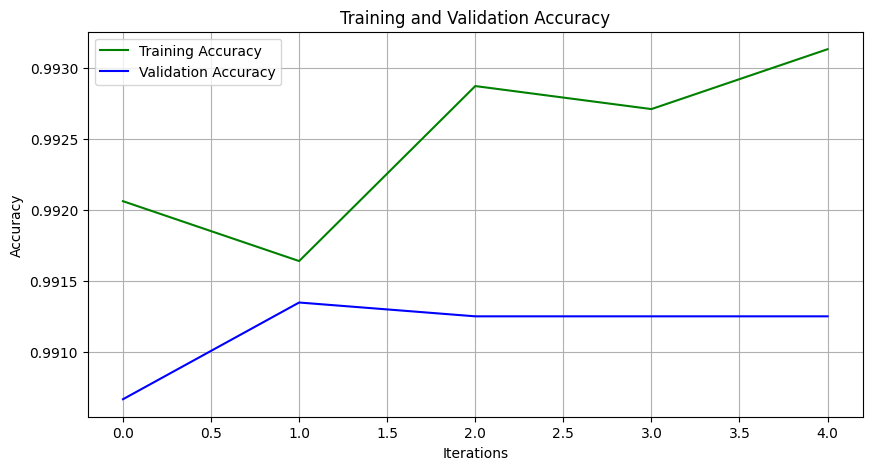

In [19]:
model_test = model

# Train model and store history

history = model_test.fit(X_train_q, y_train_tuner, validation_data=(X_val_q, y_val_tuner), epochs=5, verbose=1)

# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


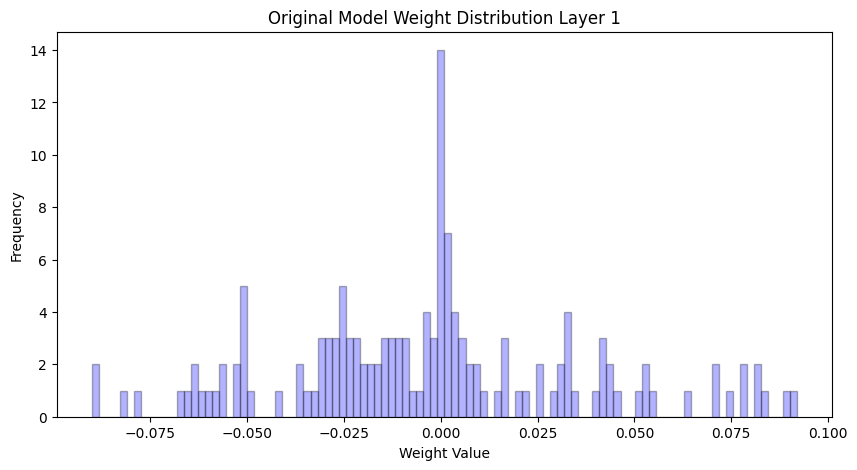

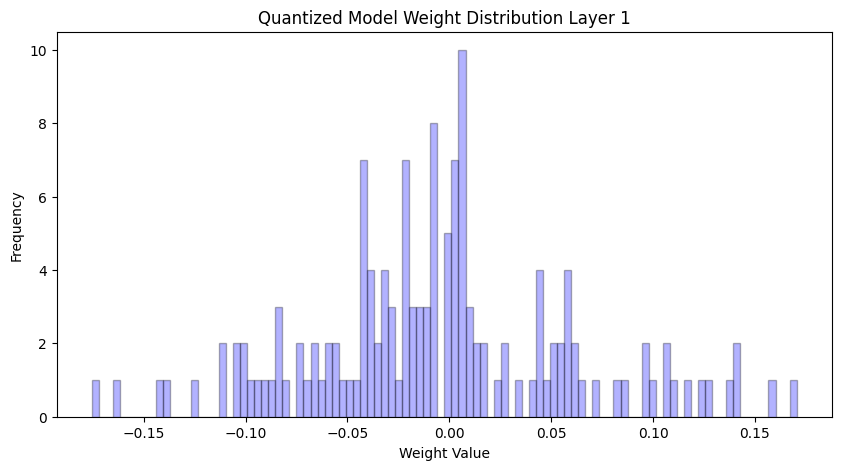

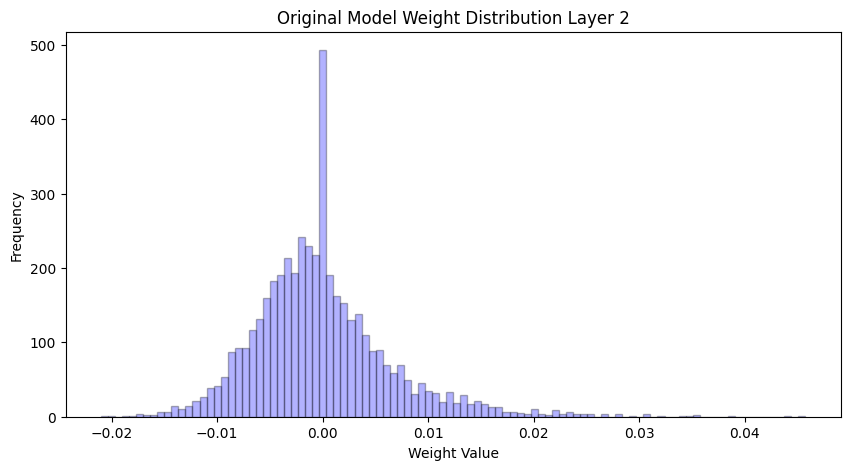

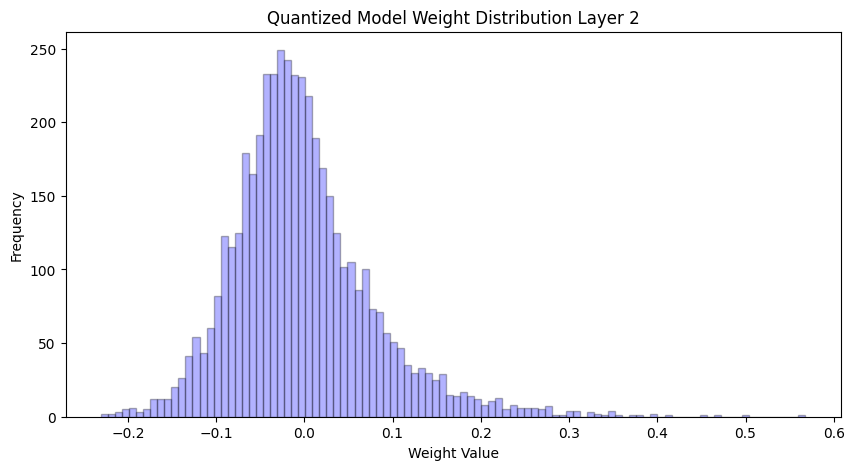

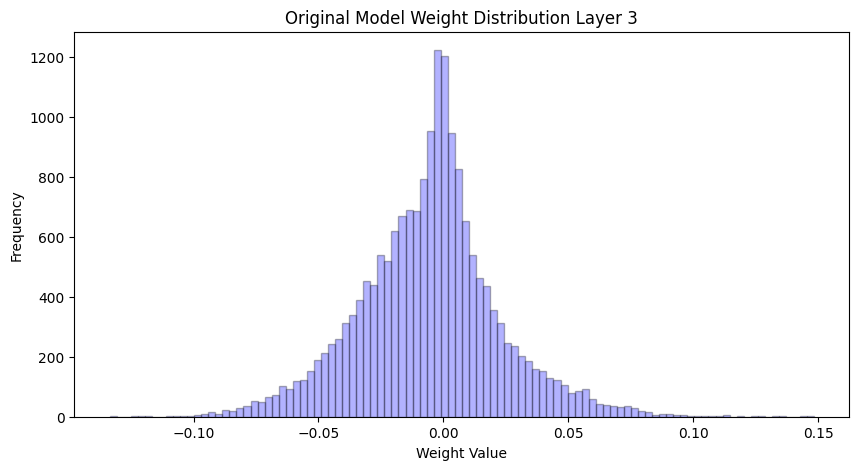

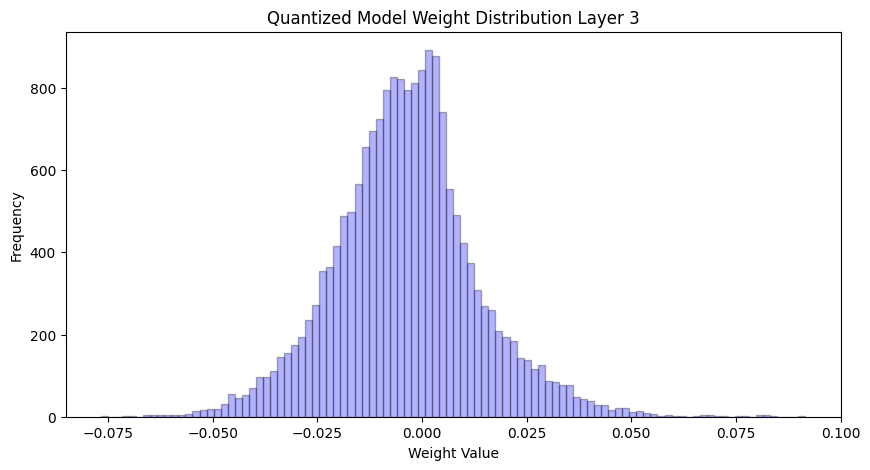

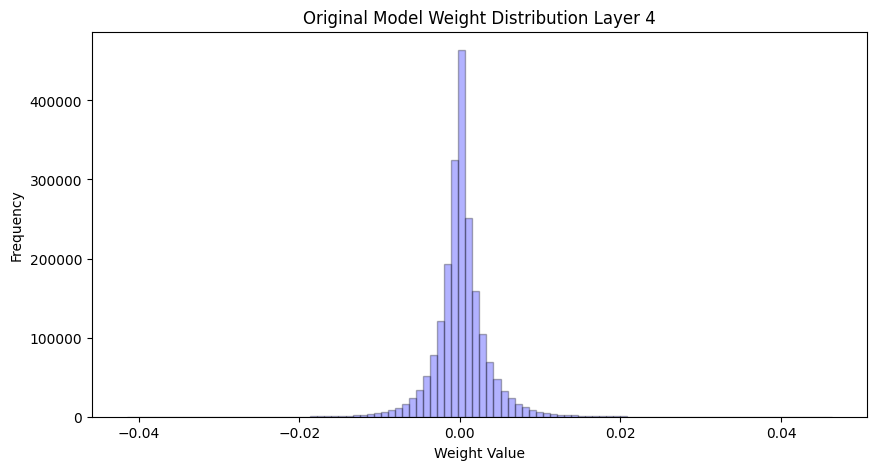

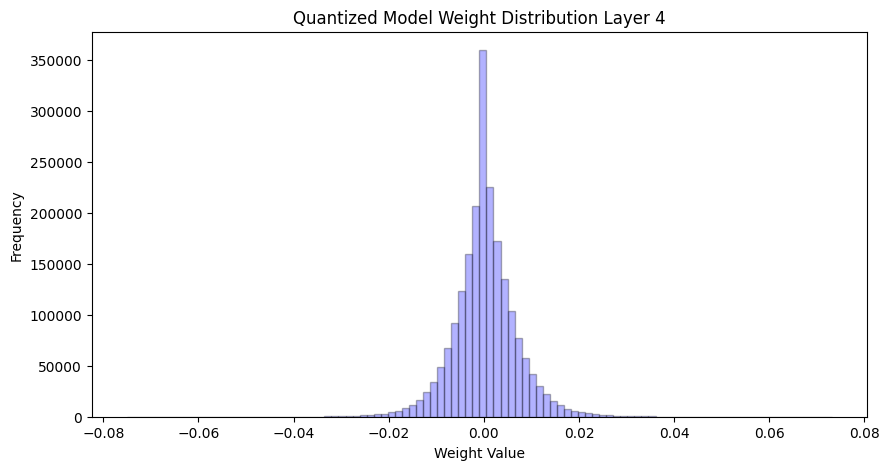

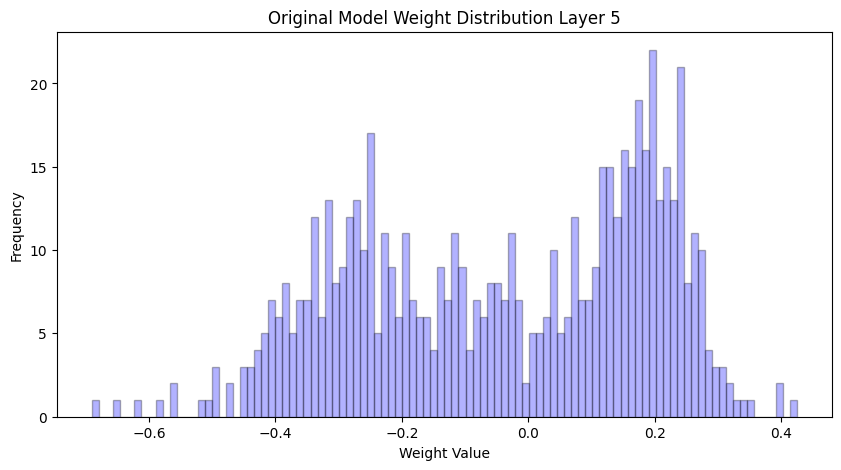

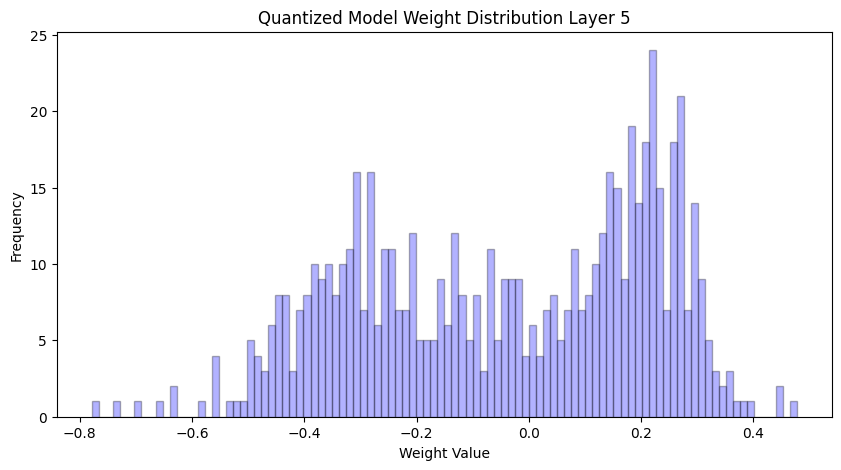

In [20]:
def Weight_Distribution():
    for i in range(0,5):
        weight_orig_model = model.weights[i*6]
        weight_orig_model = weight_orig_model.numpy()
        weight_quantized_model = quantized_model.weights[i*4]
        weight_quantized_model = weight_quantized_model.numpy()

        # Plot histogram
        plt.figure(figsize=(10, 5))
        plt.hist( weight_orig_model.flatten(), bins=100, color='b', alpha=0.3, edgecolor='black')
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        plt.title("Original Model Weight Distribution Layer "+str(i+1))
        plt.figure(figsize=(10, 5))
        plt.hist(weight_quantized_model.flatten(), bins=100, color='b', alpha=0.3, edgecolor='black')
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        plt.title("Quantized Model Weight Distribution Layer "+str(i+1))
        plt.show()
Weight_Distribution()
#weight in original model are at index 0,6,12,18,24
#weight in quantized model are at index 0,4,8,12,16

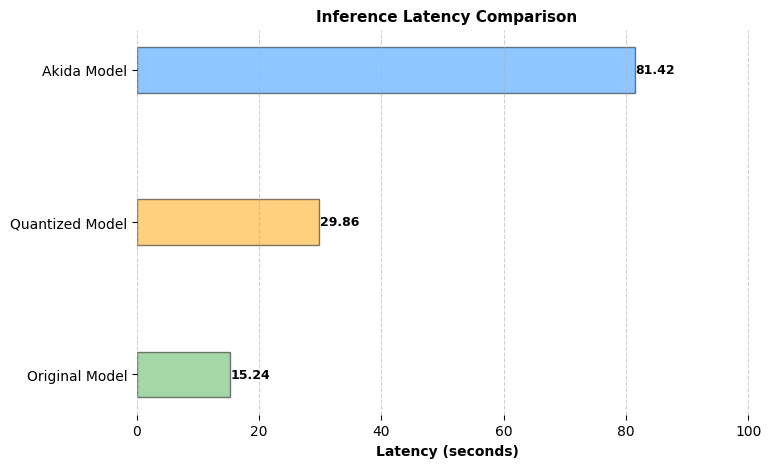

In [21]:

# Latency values in seconds (Replace these with your actual measurements)
latency_values = [orig_avg/1000, quant_avg/1000, akida_avg/1000] # Example: [original, quantized, akida]

# Model names
models_lots = ['Original Model', 'Quantized Model', 'Akida Model']

# Colors for each bar
colors = ['#4CAF50', '#FFA500', '#1E90FF']  # Green, Orange, Blue

# Create figure
plt.figure(figsize=(8, 5))

# Plot bars
bars = plt.barh(models_lots, latency_values, height=0.3,color=colors, edgecolor='black', alpha=0.5)

# Add grid lines for readability
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Labels and title
plt.xlabel("Latency (seconds)", fontsize=10, fontweight='bold')
plt.title("Inference Latency Comparison", fontsize=11, fontweight='bold')
buffer = 20  # Amount to extend the x-axis
plt.xlim(0, max(latency_values) + buffer)
# Add values inside the bars
for bar, value in zip(bars, latency_values):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, f"{value:.2f}",
             va='center', ha='left', fontsize=9, color='black', fontweight='bold')

# Remove unnecessary borders
plt.box(False)

# Show the plot
plt.show()

In [22]:
wandb.finish()

accuracy,▇▇▇▇▇█▁▆▆▆▇▁▇▇██████▆▆▇▇▇███▁▅▇▇▇▅▇▇▇▇██
epoch,▂▂▃▅▅▁▁▂▂▃▆▇▇██▅▅▆██▃▆▇▇▇█▁▂▃▃▄▆▆▇▁▄▄▆▆▇
loss,▂▂▂▂▂▁▁▄▃▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▂▂▂▂▃▂▂▂▁▁
lr,███▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁█████▂▂
val_accuracy,█████████▁▆▆▆███████████████▅███████████
val_loss,▂▂▂▂▁▅▅▄▄▃▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁█▇▄▃▂▂▂▂▂▂▂▁▁▁▁
accuracy,0.9872
best_epoch,18
best_val_loss,0.10459
epoch,19
loss,0.11787
